In [114]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt

# Parameters

In [115]:
num_dimensions=2
num_classes=3

# Functions

In [116]:
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def populate_W(X,Y,net_structure):
    net_structure=[X[0].size]+net_structure+[Y.max()+1]
    W=[]
    for i in range(len(net_structure)-1):
        W.append(np.random.randn(net_structure[i]+1,net_structure[i+1]))
    return W
def process(X,W):
    X=np.append(X,np.ones((X.shape[0],1)),1)
    return X.dot(W)
def sigmoid(v):
    return 1/(1+np.exp(-v))
def softmax(v):
    expv=np.exp(v)
    if v.shape[0]>1:
        return expv/expv.sum(axis=1,keepdims=True)
    else:
        return expv/expv.sum(axis=1)
def forward(X,W,func=sigmoid,softmax_output=True):
    v=[ X ]
    for l in range(len(W)):
        v.append(func(process(v[-1],W[l])))
    if softmax_output:
        v[-1]=softmax(v[-1])
    return v
def compute_classification_rate(Y,P):
    tot=Y.shape[0]
    return 1.0*sum([Y[i]==P[i] for i in range(tot)])/tot

# Generating some 2D data

In [117]:
num_per_class=500
r=2*num_classes/math.pi
d=2*math.pi/num_classes
centers=[[r*math.cos(n*d),r*math.sin(n*d)] for n in range(num_classes)]
X_lst=[]
for c in range(num_classes):
    X_lst.append(np.random.randn(num_per_class,2) + np.array(centers[c]))
X=np.concatenate(X_lst,axis=0)
Y=np.array([0]*num_per_class+[1]*num_per_class+[2]*num_per_class)

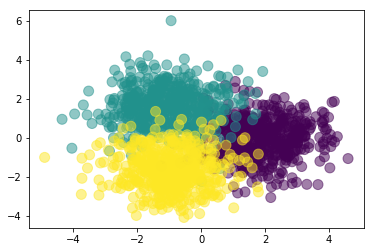

In [118]:
plt.scatter(X[:,0],X[:,1],c=Y,s=100,alpha=0.5)
plt.show()

# Feedforward

### 1 hidden layer

In [119]:
W=populate_W(X,Y,net_structure=[3])
W

[array([[-1.88486118,  0.98938124,  0.41476881],
        [ 0.13540744,  0.96044893,  0.29059981],
        [-0.73942485, -0.48189039,  1.13212092]]),
 array([[-0.03583193,  0.97163881,  0.36395655],
        [-0.96712892, -0.22405938,  1.467301  ],
        [ 1.5110296 ,  0.44867782,  0.09104124],
        [ 2.66709964, -0.33001368,  2.08239841]])]

In [120]:
preds=forward(X,W)
preds[-1]

array([[ 0.38599636,  0.23953331,  0.37447033],
       [ 0.38157805,  0.23386116,  0.38456079],
       [ 0.38164682,  0.23385008,  0.3845031 ],
       ..., 
       [ 0.37401447,  0.2690105 ,  0.35697503],
       [ 0.37035636,  0.27506793,  0.35457571],
       [ 0.36918493,  0.27636294,  0.35445213]])

In [121]:
pred_labels=np.argmax(preds[-1],axis=1)
pred_labels[:5]

array([0, 2, 2, 2, 0])

In [122]:
compute_classification_rate(Y,pred_labels)

0.12666666666666668

### 2 hidden layers

In [123]:
W=populate_W(X,Y,net_structure=[3,3])
W

[array([[ 0.34746856,  0.72384537,  0.83495241],
        [ 0.76092301,  1.53186446, -0.13814126],
        [ 1.85575948, -0.16847312, -0.60737695]]),
 array([[-0.7310788 ,  0.2665273 , -0.31413086],
        [-0.1678986 , -0.35932023, -0.01145728],
        [-1.08979089,  1.52056981,  0.05241182],
        [ 2.28794264,  0.20336235, -0.74033464]]),
 array([[-0.21921531, -0.38493081, -0.13609088],
        [-1.324147  ,  0.4978055 , -0.41930954],
        [ 0.74749377,  0.74809816, -0.89001743],
        [-1.85229325,  0.17399344,  0.69748981]])]

In [124]:
preds=forward(X,W)
preds[-1]

array([[ 0.23089238,  0.40674518,  0.36236245],
       [ 0.22986819,  0.40817732,  0.36195449],
       [ 0.22972514,  0.40868792,  0.36158694],
       ..., 
       [ 0.23362307,  0.39970306,  0.36667388],
       [ 0.23472045,  0.39873565,  0.3665439 ],
       [ 0.2340746 ,  0.39781527,  0.36811012]])

In [125]:
pred_labels=np.argmax(preds[-1],axis=1)
pred_labels[:5]

array([1, 1, 1, 1, 1])

In [126]:
compute_classification_rate(Y,pred_labels)

0.3333333333333333

# Backpropagation

## The tedious way

In [127]:
def compute_cost(T,Y):
    return -(T*np.log(Y)).sum()
def derivate(T,preds,W):
    layer=np.append(preds[0],np.ones((preds[0].shape[0],1)),1)
    delta=preds[-1]-T
    for l in reversed(range(len(W))):
        delta=delta.dot(W[l][:-1,:].T)*preds[l+1]*(1-preds[l+1])
    return layer.T.dot(delta)
def train(X,Y,net_structure,
          learning_rate=10e-7,num_rounds=100000,
          report_step=100,print_every=5000,plot_cost=True):
    reports=[]
    T=one_hot_encoder(Y)
    W=populate_W(X,Y,net_structure)
    for n in range(num_rounds):
        preds=forward(X,W)
        if n % report_step==0:
            cost=compute_cost(T,preds[-1])
            classification_rate=compute_classification_rate(Y,np.argmax(preds[-1],axis=1))
            if print_every and n % print_every==0:
                print("{} {:0.2f} {:0.2f}".format(n,cost,classification_rate))
            reports.append([n,cost,classification_rate])
        for l in reversed(range(len(W))):
            W[l]=W[l]-learning_rate*derivate(T,preds[l:],W[l+1:])
    cost=compute_cost(T,preds[-1])
    classification_rate=compute_classification_rate(Y,np.argmax(preds[-1],axis=1))
    reports.append([num_rounds,cost,classification_rate])
    if plot_cost:
        plt.plot([r[1] for r in reports])
        plt.show()
    return W, reports

### 1 hidden layer

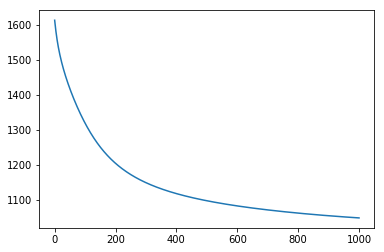

CPU times: user 1min 12s, sys: 160 ms, total: 1min 12s
Wall time: 1min 12s


In [128]:
%%time
W,report=train(X,Y,net_structure=[3],print_every=False)

In [129]:
report[-1]

[100000, 1047.6556538580876, 0.8946666666666667]

### 2 hidden layers

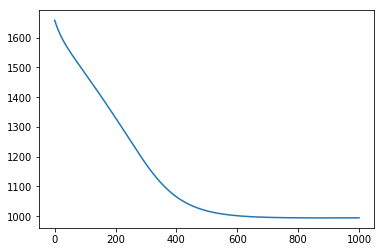

CPU times: user 1min 30s, sys: 144 ms, total: 1min 30s
Wall time: 1min 30s


In [137]:
%%time
W,report=train(X,Y,net_structure=[3,3],print_every=False)

In [138]:
report[-1]

[100000, 994.53187535662767, 0.914]

## The recursive way

In [132]:
def compute_cost(T,Y):
    return -(T*np.log(Y)).sum()
def derivate(layer,delta,W):
    next_delta=delta.dot(W[:-1,:].T)*layer*(1-layer)
    layer=np.append(layer,np.ones((layer.shape[0],1)),1)
    return layer.T.dot(delta),next_delta
def train(X,Y,net_structure,
          learning_rate=10e-7,num_rounds=100000,
          report_step=100,print_every=5000,plot_cost=True):
    reports=[]
    T=one_hot_encoder(Y)
    W=populate_W(X,Y,net_structure)
    for n in range(num_rounds):
        preds=forward(X,W)
        if n % report_step==0:
            cost=compute_cost(T,preds[-1])
            classification_rate=compute_classification_rate(Y,np.argmax(preds[-1],axis=1))
            if print_every and n % print_every==0:
                print("{} {:0.2f} {:0.2f}".format(n,cost,classification_rate))
            reports.append([n,cost,classification_rate])
        delta=preds[-1]-T
        for l in reversed(range(len(W))):
            g,d=derivate(preds[l],delta,W[l])
            delta=d
            W[l]=W[l]-learning_rate*g
    cost=compute_cost(T,preds[-1])
    classification_rate=compute_classification_rate(Y,np.argmax(preds[-1],axis=1))
    reports.append([num_rounds,cost,classification_rate])
    if plot_cost:
        plt.plot([r[1] for r in reports])
        plt.show()
    return W, reports

### 1 hidden layer

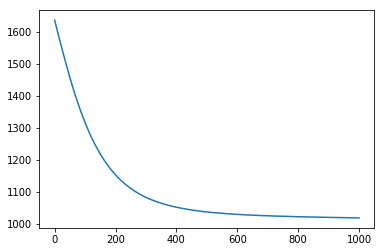

CPU times: user 1min 7s, sys: 172 ms, total: 1min 7s
Wall time: 1min 7s


In [133]:
%%time
W,report=train(X,Y,net_structure=[3],print_every=False)

In [134]:
report[-1]

[100000, 1019.0887444672688, 0.8933333333333333]

### 2 hidden layers

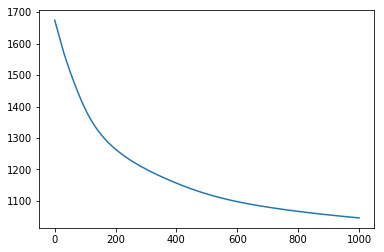

CPU times: user 1min 30s, sys: 244 ms, total: 1min 30s
Wall time: 1min 30s


In [139]:
%%time
W,report=train(X,Y,net_structure=[3,3],print_every=False)

In [140]:
report[-1]

[100000, 1046.1459847623705, 0.906]